# Torob Project: Product Category Classification Based On Images

Hi and welcome to Torob hands-on project for OpenAI machine learning bootcamp 2023! 👋 🎉

In this project, you will use the real images of a very small subset of products in Torob product catalogue for the task of "product category classification". Given a set of product images from 10 different categories, you should build a classifier model which given a product image, it would predict the category of the product.

**Note that the sections which you need to complete or write your answers are marked with 🔵 (a blue circle).**

There is also a Persian guide for this project which you can access here: https://docs.google.com/document/d/1FiWXlNUo44U1ECRG7OSKJXsC_WjMjcMSPfz7lMhbYzo/edit?usp=sharing

So, let's get started!

## ⭕ Install dependencies

▶ Since we are going to work with HuggingFace Transformers library, it needs to be installed. Further, the `gdown` and `datasets` packages are also installed which are used for downloading the data from Google Drive and loading and reading the data, respectively.

In [126]:
!pip install -q -U datasets gdown transformers

▶ And then we import the necessary libraries and modules:

In [127]:
import random

from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetModel
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

## ⭕ Download Data

▶ As the first step, we need to download the data of product images. For your convenience, it has been uploaded as a zip file on the Google Drive and can be downloaded using `gdown` command. Just run the following cell to download the data.

In [128]:
# !gdown 1DM8cKZFFU1z5fN7h34l3Ji6h5UytYMpb

## ⭕ Load Data

▶ Next, we should load the image data. The structure of the data is as follows:

```
torob-product-images
    fryer
        1.jpg
        2.jpg
        ...
    graphic-card
        1.jpg
        2.jpg
        ...
    ...
```
▶ The images for each category is in a seperate directory. We use the `load_dataset` function from HuggingFace `dataset` library to load all the images, and use the name of each directory as the label of the images.

In [129]:
dataset = load_dataset("imagefolder", data_files="./torob-product-images.zip", split='train')

Found cached dataset imagefolder (C:/Users/Lenovo/.cache/huggingface/datasets/imagefolder/default-0d0727000904a351/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


▶ Let's inspect the labels of the images to see the title of the 10 categories:

In [130]:
dataset.features['label'].names

['fryer',
 'graphic-card',
 'mens-boots',
 'mens-sandals',
 'mens-sport-shoes',
 'microwave',
 'mobile',
 'motherboard',
 'tablet',
 'toaster']

▶ Further, note that the images can be accessed via `"images"` column of the dataset (i.e. `dataset["images"]`) and their corresponding labels can be accessed using `"label"` column (i.e. `dataset["label"]`).

▶ Let's randomly select a few images and display them (the resized images are displayed here, because some of them may be big).

Label of following image: motherboard


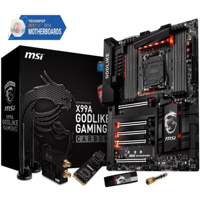

Label of following image: fryer


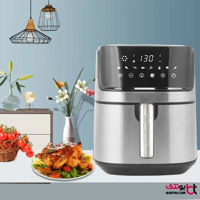

Label of following image: toaster


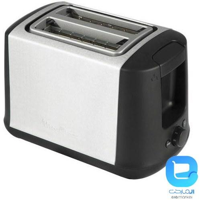

Label of following image: toaster


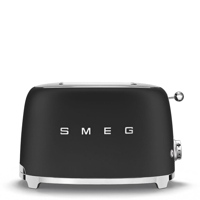

Label of following image: toaster


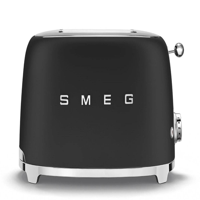

Label of following image: tablet


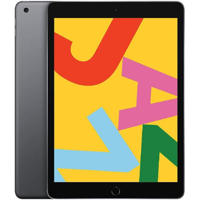

Label of following image: mens-boots


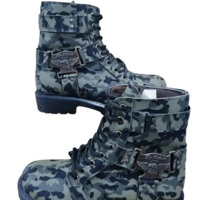

Label of following image: mens-sandals


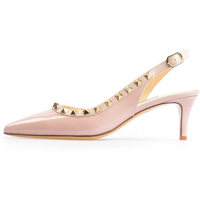

Label of following image: mens-sport-shoes


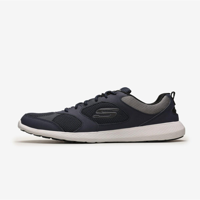

Label of following image: graphic-card


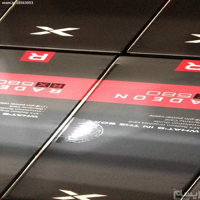

In [131]:
sampled_idx = random.sample(range(len(dataset)), k=10)
sampled_data = dataset.select(sampled_idx)
for img, lbl in zip(sampled_data["image"], sampled_data["label"]):
  print("Label of following image:", dataset.features['label'].names[lbl])
  display(img.resize((200, 200)))
  print("="*80)

## ⭕ Train-Test Split

▶ We need to split our data into train and test set so that we can evaluate the performance of different classifiers on unseen data. We use a 80/20 split (80% for train, 20% for test).

🔵 To split the dataset, we can use `train_test_split` method (it's very similar to `train_test_split` function in `sklearn` library). Replace the `???` in the following cell.

In [132]:
splited_dataset = dataset.train_test_split(test_size=0.2, stratify_by_column='label', shuffle=True, seed=42)
train_dataset = splited_dataset["train"]
test_dataset = splited_dataset["test"]

Loading cached split indices for dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-ec3f70cd2d2122a0.arrow and C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-d47bd17c0d3b15bb.arrow


## ⭕ Create a DataFrame To Store Accuracy Scores 

In [133]:
import pandas as pd

Data = {'Model' : ['KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'SVC'],
        'simple_features' : [0, 0, 0, 0, 0],
        'histogram_features' : [0, 0, 0, 0, 0],
        'resnet50_features' : [0, 0, 0, 0, 0],
        'sift_histogram_features' : [0, 0, 0, 0, 0],
        'resnet101_features' : [0, 0, 0, 0, 0],
        }

Accuracy_table = pd.DataFrame(Data)
Accuracy_table.set_index('Model', inplace=True)

## ⭕ Simple Features Extraction

▶ The first method we use for feature extraction is very simple: for each image, the **average** (mean) and **standard deviation** (std) of pixels of each channel (R, G & B) is calculated, and together they are used to represent that image. In other words, each image would be represented by only 6 (3 for average + 3 for standard deviation) numbers.

🔵 We have defined a function named `calculate_simple_features` but it's not complete. It operates on single example of the dataset to calculate the features mentioned above and stores the features in the key `"simple_features"`. Use `numpy` library (imported as `np`) to calculate the average and standard deviation of each image. Replace all the `???` to complete the implementation.

In [134]:
def calculate_simple_features(example):
  img_mean = np.mean(example["image"], axis=(0, 1))
  img_std = np.std(example["image"], axis=(0, 1))
  example["simple_features"] = np.concatenate((img_mean, img_std), axis=-1)
  return example

🔵 Now, use `map` method of the dataset to apply the above function on each example in the train and test datasets. Replace `???` with your answers.

In [135]:
train_dataset = train_dataset.map(calculate_simple_features)
test_dataset = test_dataset.map(calculate_simple_features)

Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-7c46118ea3d41aa4.arrow
Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-86f1934e5f1c454c.arrow


▶ Make sure we have correctly implemented the feature extraction step. We should see "Well done!" printed without any errors.

In [136]:
assert len(train_dataset["simple_features"][0]) == 6
assert len(test_dataset["simple_features"][0]) == 6
print("Well done!")

Well done!


## ⭕ Train and Evaluate Models on Simple Features

▶ Now, it's time to train and evaluate some models on the extracted features. We try three different classifiers: KNN, Decision Tree, and Random Forest.

In [137]:
train_dataset

Dataset({
    features: ['image', 'label', 'simple_features'],
    num_rows: 8000
})

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

**Hint:** Remember that the features are stored in `"simple_features"` column of the dataset (i.e. `train_dataset["simple_features"]`), and the labels are stored in `"label"` column.

In [138]:
knn_classifier = KNeighborsClassifier()

knn_classifier.fit(train_dataset["simple_features"] , train_dataset["label"])

KNeighborsClassifier()

🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method.

In [139]:
acc = knn_classifier.score(test_dataset["simple_features"] , test_dataset["label"] )
Accuracy_table.loc['KNN', 'simple_features'] = acc
acc

0.327

### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [140]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_dataset["simple_features"] , train_dataset["label"])

DecisionTreeClassifier()

🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [141]:
acc = dt_classifier.score(test_dataset["simple_features"] , test_dataset["label"])
Accuracy_table.loc['Decision Tree', 'simple_features'] = acc
acc

0.2805

### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [142]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_dataset["simple_features"] , train_dataset["label"])

RandomForestClassifier()

🔵 And again we need to find the accuracy of trained classifier on the test data.

In [143]:
acc = rf_classifier.score(test_dataset["simple_features"] , test_dataset["label"] )
Accuracy_table.loc['Random Forest', 'simple_features'] = acc
acc

0.3685

### 🔵 Naive Bayes Classifier

In [144]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_dataset["simple_features"] , train_dataset["label"])

GaussianNB()

In [145]:
acc = nb_classifier.score(test_dataset["simple_features"] , test_dataset["label"] )
Accuracy_table.loc['Naive Bayes', 'simple_features'] = acc
acc

0.205

### 🔵 SVR Classifier

In [146]:
svr_classifier = SVC()
svr_classifier.fit(train_dataset["simple_features"] , train_dataset["label"])

SVC()

In [147]:
acc = svr_classifier.score(test_dataset["simple_features"] , test_dataset["label"] )
Accuracy_table.loc['SVC', 'simple_features'] = acc

## ⭕ Histogram Features Extraction

▶ The second method we use for feature extraction is more complex than the first method: for each image, the histogram of pixel values is calculated, and this histogram is used to represent that image. In other words, each image would be represented by *b* numbers, where *b* is the number of bins in the histogram. We expect this method to peform better than the previous method of feature extraction.

🔵 We have defined a function named `calculate_histogram_features` but it's not complete. It operates on single example of the dataset to calculate the histogram of the image and store it in the column `"histogram_features"`. Use `numpy` library (imported as `np`) to calculate the histogram of each image. Replace all the `???` to complete the implementation.

In [148]:
def calculate_histogram_features(example, n_bins=16):
  img_hist, _ = np.histogram(example["image"], bins=n_bins, range=(0, 255))
  # We normalize the histogram values so it would be independent of the size of image.
  img_hist = img_hist / img_hist.sum()
  example["histogram_features"] = img_hist
  return example

🔵 Now, use the above function and apply it on train and test images using `map` method to calculate their histogram features. Replace `???` with your answers.

In [149]:
train_dataset = train_dataset.map(calculate_histogram_features)
test_dataset = test_dataset.map(calculate_histogram_features)

Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-1533651b70bcbdfd.arrow
Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-ca6220268adffbb6.arrow


▶ Make sure we have correctly implemented the feature extraction step. We should see "Well done!" printed without any errors.

In [150]:
assert len(train_dataset["histogram_features"][0]) == 16
assert len(test_dataset["histogram_features"][0]) == 16
print("Well done!")

Well done!


## ⭕ Train and Evaluate Models on Histogram Features

▶ Like the simple features, we would like to evaluate the performance of the models using histogram features we just calculated.

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

In [151]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_dataset["histogram_features"] , train_dataset["label"])

KNeighborsClassifier()

🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method.

In [152]:
acc = knn_classifier.score(test_dataset["histogram_features"] , test_dataset["label"])
Accuracy_table.loc['KNN', 'histogram_features'] = acc
acc

0.392

### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [153]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_dataset["histogram_features"] , train_dataset["label"])

DecisionTreeClassifier()

🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [154]:
acc = dt_classifier.score(test_dataset["histogram_features"] , test_dataset["label"] )
Accuracy_table.loc['Decision Tree', 'histogram_features'] = acc
acc

0.3525

### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [155]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_dataset["histogram_features"] , train_dataset["label"])

RandomForestClassifier()

🔵 And again we need to find the accuracy of trained classifier on the test data.

In [156]:
acc = rf_classifier.score(test_dataset["histogram_features"] , test_dataset["label"] )
Accuracy_table.loc['Random Forest', 'histogram_features'] = acc
acc

0.4875

### 🔵 Naive Bayes Classifier

In [157]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_dataset["histogram_features"] , train_dataset["label"])

GaussianNB()

In [158]:
acc = nb_classifier.score(test_dataset["histogram_features"] , test_dataset["label"] )
Accuracy_table.loc['Naive Bayes', 'histogram_features'] = acc
acc

0.2385

### 🔵 SVR Classifier

In [159]:
svr_classifier = SVC()
svr_classifier.fit(train_dataset["histogram_features"] , train_dataset["label"])

SVC()

In [160]:
acc = svr_classifier.score(test_dataset["histogram_features"] , test_dataset["label"] )
Accuracy_table.loc['SVC', 'histogram_features'] = acc

## ⭕ Pretrained Model (ResNet) Features Extraction

▶ The third and final method we use for feature extraction is based on using a pretrained CNN (Convolutional Neural Network): for each image, we use a pretrained ResNet model to extract its features. In other words, each image would be represented by the features of the last layer of the ResNet model which is equal to 2048 numbers.

🔵 We use the HuggingFace Transformers library to download and load the preprocessor as well as the model weights of the **ResNet-50** model which has been already trained on ImageNet dataset. Replace all the `???` to download and load the pretrained preprocessors and model.

In [161]:
resnet50_img_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
resnet50_model = ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


▶ Next, we define a function to apply these two operations on a batch of images:

- Use the ResNet preprocessor to preprocess the images (e.g. resize, normalizing the pixel values, etc.) so that they are ready to be fed to the ResNet model,
- Apply the ResNet model on the preprocessed images to extract their features. As you can see, we use the output of last "pooler layer" as the features.

🔵 Use ResNet preprocessor and model to extract features from the images. For that, you need to complete the implementation of the following function. Replace all the `???` with your answers.

In [162]:
def calculate_resnet_features(examples):
  inputs = resnet50_img_processor(examples["image"], return_tensors="pt")
  with torch.no_grad():
    features = resnet50_model(**inputs).pooler_output.squeeze().numpy()
  examples["resnet50_features"] = features
  return examples

🔵 Now, use the above function and apply it on train and test images using `map` method of dataset to extract features using ResNet model. Replace `???` with your answers.

In [163]:
train_dataset = train_dataset.map(calculate_resnet_features, batched=True, batch_size=64)
test_dataset = test_dataset.map(calculate_resnet_features, batched=True, batch_size=64)

Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-6f9e49c8007418d0.arrow
Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-8acf470810283834.arrow


In [164]:
assert len(train_dataset[0]["resnet50_features"]) == 2048
assert len(test_dataset[0]["resnet50_features"]) == 2048

## ⭕ Train and Evaluate Models on ResNet Features

▶ Now that we have extracted features using ResNet model, we can train and evaluated a classifier on these features. **We expect these features to perform much better than the two previous methods for extracting features and that's due to the power of pretrained features and transfer learning.**

### 🔵 KNN Classifier

Train a **KNN** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_neighbors`, and tune them (but it's not necessary).

In [165]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_dataset["resnet50_features"] , train_dataset["label"])

KNeighborsClassifier()

🔵 Now, find the accuracy of trained classifier on the test data.

**Hint:** You can use `score` method.

In [166]:
acc = knn_classifier.score(test_dataset["resnet50_features"] , test_dataset["label"])
Accuracy_table.loc['KNN', 'resnet50_features'] = acc
acc

0.915

### 🔵 Decision Tree Classifier

Next, we train a **decision tree** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `max_depth`, and tune them (but it's not necessary).

In [167]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_dataset["resnet50_features"] , train_dataset["label"])

DecisionTreeClassifier()

🔵 Like before, we would like to find the accuracy of trained classifier on the test data.

**Hint:** Still you can use `score` method!

In [168]:
acc = dt_classifier.score(test_dataset["resnet50_features"] , test_dataset["label"])
Accuracy_table.loc['Decision Tree', 'resnet50_features'] = acc
acc

0.8145

### 🔵 Random Forest Classifier

And another classifier: we train a **random forest** classifier on the extracted features for the training data. We can use the `sklearn` library for this purpose.

You can play with the hyper-parameters of the classifier, e.g. `n_estimators`, and tune them (but it's not necessary).

In [169]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_dataset["resnet50_features"] , train_dataset["label"])

RandomForestClassifier()

🔵 And again we need to find the accuracy of trained classifier on the test data.

In [170]:
acc = rf_classifier.score(test_dataset["resnet50_features"] , test_dataset["label"])
Accuracy_table.loc['Random Forest', 'resnet50_features'] = acc
acc

0.9065

### 🔵 Naive Bayes Classifier

In [171]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_dataset["resnet50_features"] , train_dataset["label"])

GaussianNB()

In [172]:
acc = nb_classifier.score(test_dataset["resnet50_features"] , test_dataset["label"])
Accuracy_table.loc['Naive Bayes', 'resnet50_features'] = acc
acc

0.8505

### 🔵 SVR Classifier

In [173]:
svr_classifier = SVC()
svr_classifier.fit(train_dataset["resnet50_features"] , train_dataset["label"])

SVC()

In [174]:
acc = svr_classifier.score(test_dataset["resnet50_features"] , test_dataset["label"] )
Accuracy_table.loc['SVC', 'resnet50_features'] = acc

## 🔵 Open Tasks

Now, here are some more tasks which you need to answer:

1. Implement a different method for extracting features from an image. And then compare its performance with the methods you tried above.

2. Use another classifier besides the three classifiers mentioned above. Can you find a more powerful classifier?

3. The ResNet is actually a family of models [with different sizes](https://huggingface.co/models?sort=downloads&search=microsoft%2Fresnet-) (e.g. `resnet-50`, `resnet-18`, `resnet-101`) , and its bigger models usually have a higher performance. Use a bigger version of ResNet model (using Transformers library as above) and see if it can improve the performance of classification.

4. Create a table which contains the performance of various models as well as different feature extraction methods you have tried in this notebook. Optionally, you can create it as a Pandas Dataframe using the `pandas` library.

Congratulations for reaching so far! 👏 We hope you have enjoyed doing this project and learned many things. 🎉 Good luck and have fun! 🙌

### ⭕ Scale-Invariant Feature Transform (SIFT) method for extracting features from an image

In [175]:
!pip install opencv-contrib-python 

In [176]:
import cv2
import numpy as np

def calculate_sift_histogram_features(example, n_bins=16):
    image = np.array(example["image"])
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    orientations = np.array([keypoint.angle for keypoint in keypoints])
    hist, _ = np.histogram(orientations, bins=n_bins, range=(0, 360))
    hist = hist / (hist.sum()+0.01)  
    
    
    example["sift_histogram_features"] = hist
    
    return example

In [177]:
train_dataset = train_dataset.map(calculate_sift_histogram_features)
test_dataset = test_dataset.map(calculate_sift_histogram_features)

Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-903046019a657c10.arrow
Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-8ce2a937681d12e7.arrow


#### 🔵 KNN Classifier

In [178]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_dataset["sift_histogram_features"] , train_dataset["label"])

KNeighborsClassifier()

In [179]:
acc = knn_classifier.score(test_dataset["sift_histogram_features"] , test_dataset["label"])
Accuracy_table.loc['KNN', 'sift_histogram_features'] = acc
acc

0.4085

#### 🔵 Decision Tree Classifier

In [180]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_dataset["sift_histogram_features"] , train_dataset["label"])

DecisionTreeClassifier()

In [181]:
acc = dt_classifier.score(test_dataset["sift_histogram_features"] , test_dataset["label"])
Accuracy_table.loc['Decision Tree', 'sift_histogram_features'] = acc
acc

0.3245

#### 🔵 Random Forest Classifier

In [182]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_dataset["sift_histogram_features"] , train_dataset["label"])

RandomForestClassifier()

In [183]:
acc = rf_classifier.score(test_dataset["sift_histogram_features"] , test_dataset["label"])
Accuracy_table.loc['Random Forest', 'sift_histogram_features'] = acc
acc

0.478

#### 🔵 Naive Bayes Classifier

In [184]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_dataset["sift_histogram_features"] , train_dataset["label"])

GaussianNB()

In [185]:
acc = nb_classifier.score(test_dataset["sift_histogram_features"] , test_dataset["label"])
Accuracy_table.loc['Naive Bayes', 'sift_histogram_features'] = acc
acc

0.335

#### 🔵 SVR Classifier

In [186]:
svr_classifier = SVC()
svr_classifier.fit(train_dataset["sift_histogram_features"] , train_dataset["label"])

SVC()

In [187]:
acc = svr_classifier.score(test_dataset["sift_histogram_features"] , test_dataset["label"] )
Accuracy_table.loc['SVC', 'sift_histogram_features'] = acc

### ⭕ Pretrained Model (ResNet101) Features Extraction

In [188]:
resnet101_img_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-101")
resnet101_model = ResNetModel.from_pretrained("microsoft/resnet-101")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at microsoft/resnet-101 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [189]:
def calculate_resnet101_features(examples):
  inputs = resnet101_img_processor(examples["image"], return_tensors="pt")
  with torch.no_grad():
    features = resnet101_model(**inputs).pooler_output.squeeze().numpy()
  examples["resnet101_features"] = features
  return examples

In [190]:
train_dataset = train_dataset.map(calculate_resnet101_features, batched=True, batch_size=64)
test_dataset = test_dataset.map(calculate_resnet101_features, batched=True, batch_size=64)

Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-136b203891ffc272.arrow
Loading cached processed dataset at C:\Users\Lenovo\.cache\huggingface\datasets\imagefolder\default-0d0727000904a351\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-2596067553f3ecf6.arrow


#### 🔵 KNN Classifier

In [191]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_dataset["resnet101_features"] , train_dataset["label"])

KNeighborsClassifier()

In [192]:
acc = knn_classifier.score(test_dataset["resnet101_features"] , test_dataset["label"])
Accuracy_table.loc['KNN', 'resnet101_features'] = acc
acc

0.914

#### 🔵 Decision Tree Classifier

In [193]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_dataset["resnet101_features"] , train_dataset["label"])

DecisionTreeClassifier()

In [194]:
acc = dt_classifier.score(test_dataset["resnet101_features"] , test_dataset["label"])
Accuracy_table.loc['Decision Tree', 'resnet101_features'] = acc
acc

0.7795

#### 🔵 Random Forest Classifier

In [195]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_dataset["resnet101_features"], train_dataset["label"])

RandomForestClassifier()

In [196]:
acc = rf_classifier.score(test_dataset["resnet101_features"] , test_dataset["label"])
Accuracy_table.loc['Random Forest', 'resnet101_features'] = acc
acc

0.9185

#### 🔵 Naive Bayes Classifier

In [197]:
nb_classifier = GaussianNB()
nb_classifier.fit(train_dataset["resnet101_features"], train_dataset["label"])

GaussianNB()

In [198]:
acc = nb_classifier.score(test_dataset["resnet101_features"] , test_dataset["label"])
Accuracy_table.loc['Naive Bayes', 'resnet101_features'] = acc
acc

0.8615

#### 🔵 SVR Classifier

In [199]:
svr_classifier = SVC()
svr_classifier.fit(train_dataset["resnet101_features"] , train_dataset["label"])

SVC()

In [202]:
acc = svr_classifier.score(test_dataset["resnet101_features"] , test_dataset["label"] )
Accuracy_table.loc['SVC', 'resnet101_features'] = acc
acc

0.9405

### ⭕ See The Table

In [201]:
Accuracy_table

,simple_features,histogram_features,resnet50_features,sift_histogram_features,resnet101_features
Model,,,,,
KNN,0.3270,0.3920,0.9150,0.4085,0.9140
Decision Tree,0.2805,0.3525,0.8145,0.3245,0.7795
Random Forest,0.3685,0.4875,0.9065,0.4780,0.9185
Naive Bayes,0.2050,0.2385,0.8505,0.3350,0.8615
SVC,0.3010,0.3905,0.9415,0.4630,0.9405
